In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
#import nltk
#nltk.download('wordnet')
import regex
import spacy
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv('tweets.csv')

In [3]:
df['user_timezone'] = df['user_timezone'].fillna(method='ffill')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   14640 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB
None


In [4]:
c= dict(df['user_timezone'].value_counts().head(10))
c1 = list(c.keys())
c2 = list(c.values())
print(c1,c2)

['Eastern Time (US & Canada)', 'Central Time (US & Canada)', 'Pacific Time (US & Canada)', 'Quito', 'Atlantic Time (Canada)', 'Mountain Time (US & Canada)', 'Arizona', 'London', 'Alaska', 'Sydney'] [5551, 2930, 1803, 1093, 747, 547, 322, 291, 158, 151]


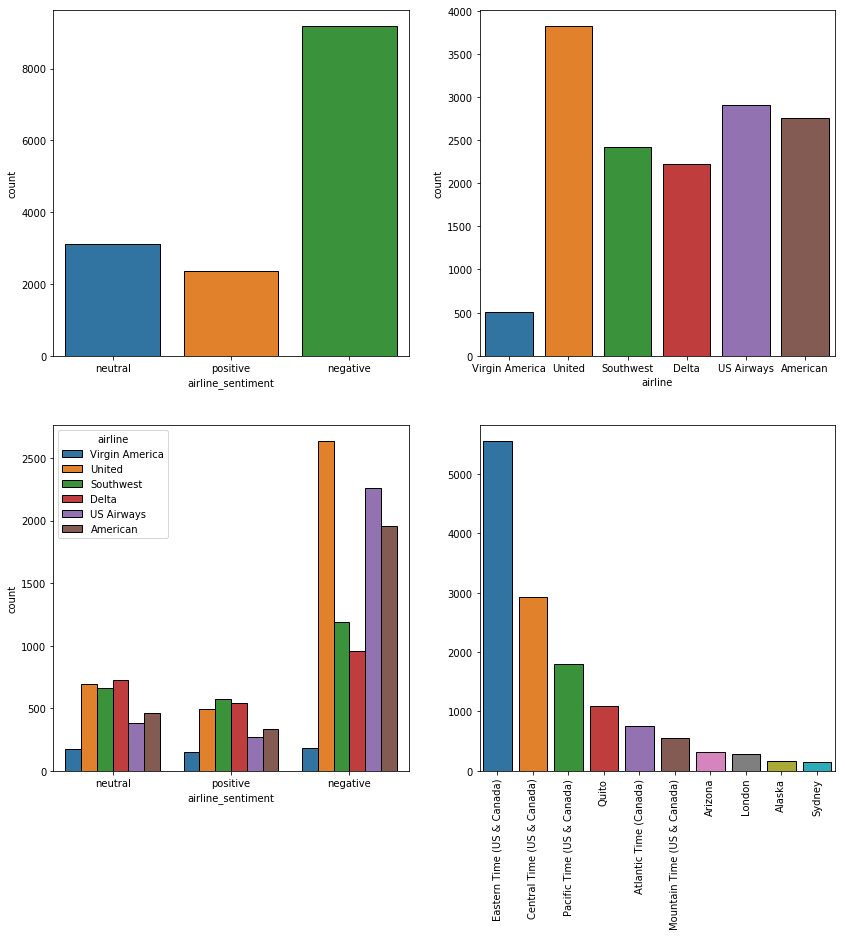

In [5]:
import seaborn as sns
f = plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.countplot(x='airline_sentiment',data=df,edgecolor='black')
plt.subplot(2,2,2)
sns.countplot(x='airline',data=df,edgecolor='black')
plt.subplot(2,2,3)
sns.countplot(x='airline_sentiment',data=df,hue='airline',edgecolor='black')
plt.subplot(2,2,4)
ax = sns.barplot(c1,c2,edgecolor='black')
ax.set_xticklabels(c1,rotation=90)

plt.show()

In [6]:
reason = dict(df['negativereason'].value_counts(dropna=True))
reason1 = list(reason.keys())
reason2 = list(reason.values())
print(reason1,reason2)

['Customer Service Issue', 'Late Flight', "Can't Tell", 'Cancelled Flight', 'Lost Luggage', 'Bad Flight', 'Flight Booking Problems', 'Flight Attendant Complaints', 'longlines', 'Damaged Luggage'] [2910, 1665, 1190, 847, 724, 580, 529, 481, 178, 74]


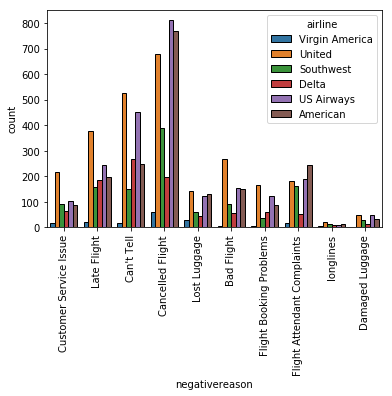

In [7]:
ax= sns.countplot(x='negativereason',data=df,hue='airline',edgecolor='black')
ax.set_xticklabels(reason1,rotation=90)
plt.show()

In [8]:
# Downsample majority class
from sklearn.utils import resample
df_majority = df[df.airline_sentiment=='negative']
df_minority = df[df.airline_sentiment=='positive']
 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2363,     # to match minority class
                                 random_state=123) # reproducible results



# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_majority = df[df.airline_sentiment=='neutral']
df_minority = df_downsampled[df_downsampled.airline_sentiment=='positive']
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2363,     # to match minority class
                                 random_state=123) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_downsampled])

# Display new class counts
df_downsampled.airline_sentiment.value_counts()


neutral     2363
negative    2363
positive    2363
Name: airline_sentiment, dtype: int64

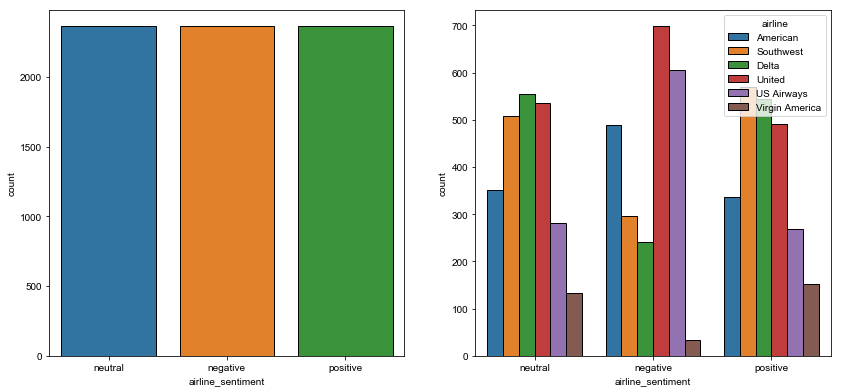

In [9]:
import seaborn as sns
f = plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.countplot(x='airline_sentiment',data=df_downsampled,edgecolor='black')
plt.subplot(2,2,2)
sns.countplot(x='airline_sentiment',data=df_downsampled,hue='airline',edgecolor='black')
sns.set_style('darkgrid')
plt.show()

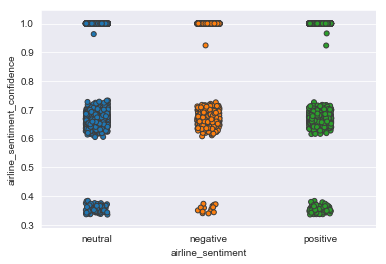

In [10]:
_ = sns.stripplot(x='airline_sentiment',y='airline_sentiment_confidence',data=df_downsampled,jitter=True,linewidth=1,dodge=True)
sns.set_style('darkgrid')

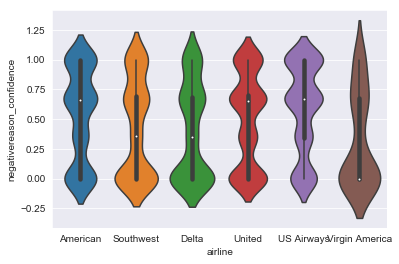

In [11]:
_ = sns.violinplot(x='airline',y='negativereason_confidence',data=df_downsampled)

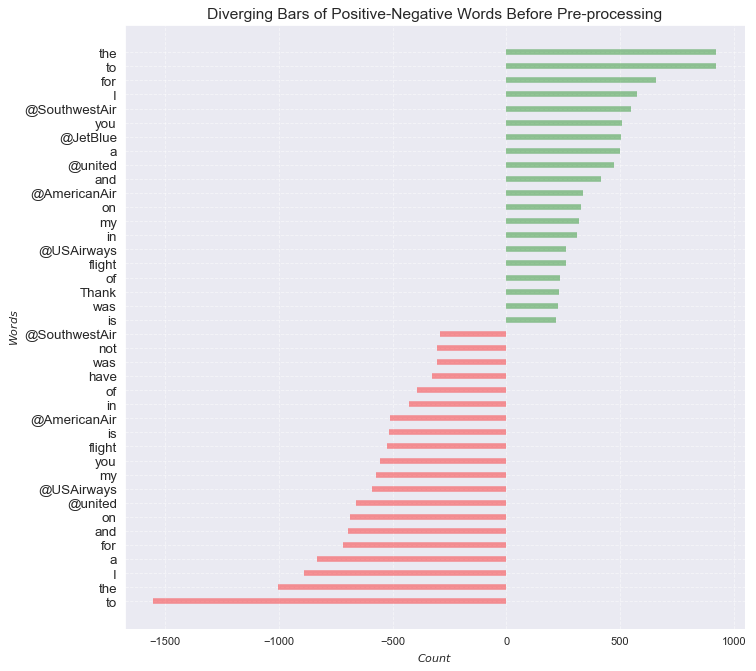

In [12]:
pos = df_downsampled[df_downsampled['airline_sentiment'] == 'positive']
neg = df_downsampled[df_downsampled['airline_sentiment'] == 'negative']

posbiglist = [word.split() for word in pos['text']]
negbiglist = [word.split() for word in neg['text']]

poslist = []
neglist = []
for sublist in posbiglist:
    for word in sublist:
        poslist.append(word)

for sublist in negbiglist:
    for word in sublist:
        neglist.append(word)
    
pos_count = Counter(poslist)
neg_count = Counter(neglist)

pos_mc = pos_count.most_common(20)
neg_mc = neg_count.most_common(20)

a = pd.DataFrame.from_records(pos_mc,columns=['Word','Counts'])
b = pd.DataFrame.from_records(neg_mc,columns=['Word','Counts'])
b['Counts'] = -b['Counts']
c = a.append(b,ignore_index=True)
c['colors'] = ['red' if x < 0 else 'green' for x in c['Counts']]
c.sort_values('Counts',inplace = True)
c.reset_index(inplace=True)


# Draw plot
plt.figure(figsize=(10,10), dpi= 80)
plt.hlines(y=c.index, xmin=0, xmax=c.Counts, color=c.colors, alpha=0.4, linewidth=5)
sns.set_style('darkgrid')
# Decorations
plt.gca().set(ylabel='$Words$', xlabel='$Count$')
plt.yticks(c.index, c.Word, fontsize=12)
plt.title('Diverging Bars of Positive-Negative Words Before Pre-processing', fontdict={'size':14})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [15]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                    "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                    "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                    "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                    "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": 
                    "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                    "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                    "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                    "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                    "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
                    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", 
                    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                    "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
                    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                    "you'll've": "you will have", "you're": "you are", "you've": "you have"}



In [16]:
def expand(text):
    x = ''   
    for t in text.split():
        if t in contraction_dict.keys():
            t = contraction_dict[t]
        x = x + ' ' + t
    return x  

In [17]:
def tweet_to_words(raw_tweet):
    tweets = expand(raw_tweet)
    tweets = re.sub(r'(\w)(\1{2,})', r'\1',tweets)
    letters_only = re.sub("[^a-zA-Z]", " ",tweets) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    meaningful_words = [word for word in meaningful_words if len(word) > 2] 
    meaningful_words = [word for word in meaningful_words
                            if 'http' not in word
                                and 'www' not in word]
                                
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    return( " ".join( meaningful_words ))

df_downsampled['cleaned_text'] = df_downsampled.text.apply(lambda tweets: tweet_to_words(tweets))

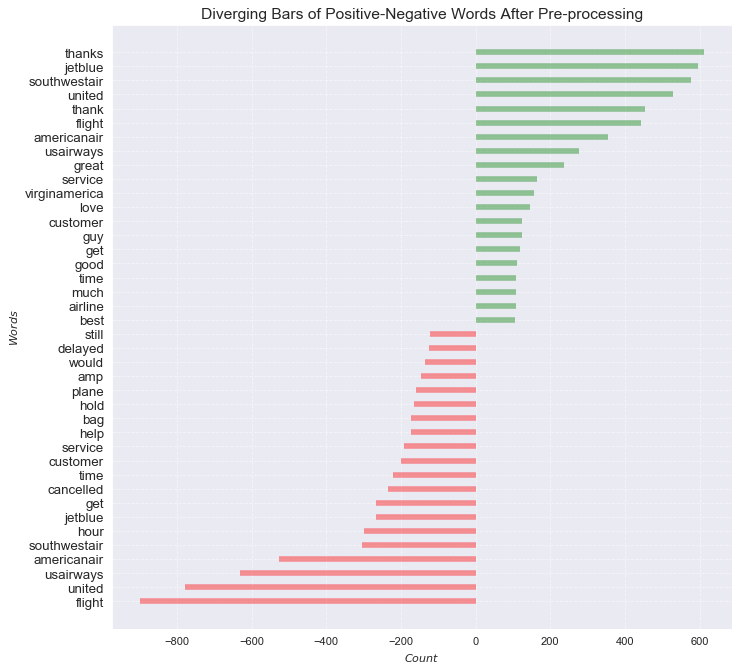

In [18]:
pos = df_downsampled[df_downsampled['airline_sentiment'] == 'positive']
neg = df_downsampled[df_downsampled['airline_sentiment'] == 'negative']

posbiglist = [word.split() for word in pos['cleaned_text']]
negbiglist = [word.split() for word in neg['cleaned_text']]

poslist = []
neglist = []
for sublist in posbiglist:
    for word in sublist:
        poslist.append(word)

for sublist in negbiglist:
    for word in sublist:
        neglist.append(word)
    
pos_count = Counter(poslist)
neg_count = Counter(neglist)

pos_mc = pos_count.most_common(20)
neg_mc = neg_count.most_common(20)

a = pd.DataFrame.from_records(pos_mc,columns=['Word','Counts'])
b = pd.DataFrame.from_records(neg_mc,columns=['Word','Counts'])
b['Counts'] = -b['Counts']
c = a.append(b,ignore_index=True)
c['colors'] = ['red' if x < 0 else 'green' for x in c['Counts']]
c.sort_values('Counts',inplace = True)
c.reset_index(inplace=True)


# Draw plot
plt.figure(figsize=(10,10), dpi= 80)
plt.hlines(y=c.index, xmin=0, xmax=c.Counts, color=c.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='$Words$', xlabel='$Count$')
plt.yticks(c.index, c.Word, fontsize=12)
plt.title('Diverging Bars of Positive-Negative Words After Pre-processing', fontdict={'size':14})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [13]:
def generate_ngrams(s, n):
    token = s.split(" ")
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

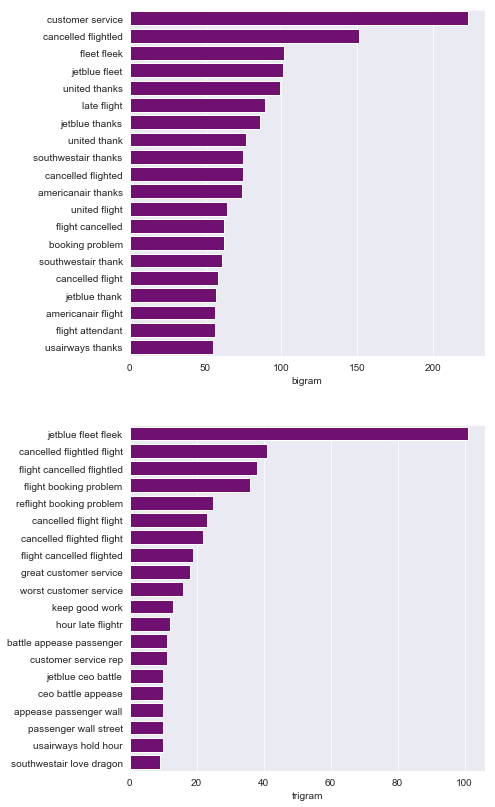

In [19]:
bigrams = df_downsampled.cleaned_text.apply(lambda tweets: generate_ngrams(tweets,2))
trigrams = df_downsampled.cleaned_text.apply(lambda tweets: generate_ngrams(tweets,3))
bigrams_list = []
trigrams_list = []
for item in bigrams:
    for i in item:
        bigrams_list.append(i)

for item in trigrams:
    for i in item:
        trigrams_list.append(i)
c = Counter(bigrams_list)
d = Counter(trigrams_list)
c = pd.DataFrame(c.most_common(20))
d = pd.DataFrame(d.most_common(20))
c.columns = ['bigram','bigram_count']
d.columns = ['trigram','trigram_count']
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
ax = sns.barplot(x='bigram_count',y='bigram',data=c,color='purple')
ax.set(ylabel="",
       xlabel="bigram")
plt.subplot(2,2,3)
ax = sns.barplot(x='trigram_count',y='trigram',data=d,color='purple')
ax.set(ylabel="",
       xlabel="trigram")
plt.show()

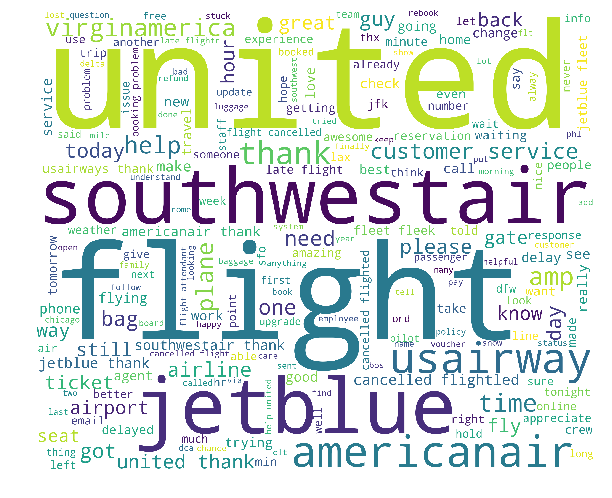

In [20]:
from wordcloud import WordCloud

cleaned_word = ' '.join([word for sentence in df_downsampled['cleaned_text'] for word in sentence.split()])

wordcloud = WordCloud(
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()